In [1]:
import numpy as np
import sys

sys.path.append('../code/')
from ode import ODEInt
from tests import Test_ODEInt
from utilities import Utilities

from time import time

import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib as mpl
import matplotlib.colors as pltcol
import gc

ut = Utilities()

In [2]:
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['legend.fontsize'] = 14 # 14
mpl.rcParams['legend.labelspacing'] = 0.25
FS = 18
FS2 = 15
FS3 = 13
FSL = 22

mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.minor.size'] = 3

#mpl.rcParams.keys()

# ODE Examples 
### Using generic (semi-)explicit schema and specialized (semi-)implicit schema

## Simple harmonic oscillator

### Problem setup

In [3]:
from examples import SimpleHarmonicOscillator
sho = SimpleHarmonicOscillator()

In [4]:
# SHO problem definition
period = 1.0
omega = 2*np.pi/period

# Initial conditions
u0,v0 = 1.0,0.0

### ODE Setup

In [5]:
odict = {}
sdict = {}
for scheme in ['verlet','f_euler','euler_cromer','stoermer_verlet']:
    setup = {'scheme':scheme,'f_ut':sho.f_ut}
    os = ODEInt(setup=setup)
    odict[scheme] = os
    sdict[scheme] = setup

# useful dictionary for plotting
pltdict = {}
pltdict['verlet'] = {'ls':'-','lw':1.0,'col':'k','lab':'Verlet integration'}
pltdict['f_euler'] = {'ls':'--','lw':1.0,'col':'gray','lab':'Forward Euler'}
pltdict['euler_cromer'] = {'ls':'-','lw':1.0,'col':'indigo','lab':'Euler-Cromer'}
pltdict['stoermer_verlet'] = {'ls':'-','lw':1.0,'col':'crimson','lab':'St${{\\rm \\"o}}$rmer-Verlet'}
pltdict['exact'] = {'ls':':','lw':1.0,'col':'k','lab':'exact'}

---------------
ODE integration
---------------
... solving u''(t) = f(u,t) + g(v) with v = u'
... using scheme: verlet
... g_v is None
... setup complete
---------------
---------------
ODE integration
---------------
... solving u''(t) = f(u,t) + g(v) with v = u'
... using scheme: f_euler
... g_v is None
... setup complete
---------------
---------------
ODE integration
---------------
... solving u''(t) = f(u,t) + g(v) with v = u'
... using scheme: euler_cromer
... g_v is None
... setup complete
---------------
---------------
ODE integration
---------------
... solving u''(t) = f(u,t) + g(v) with v = u'
... using scheme: stoermer_verlet
... g_v is None
... setup complete
---------------


### First use

In [6]:
T = 10.0 # integration range
dt = 0.01 # grid spacing

soln = {}
start_time = time()
for scheme in odict.keys():
    u,v,t = odict[scheme].solver(T,dt,u0,v0,theta_f=[omega])
    soln[scheme] = {'u':u,'v':v,'t':t}

u_exact = sho.u_exact(soln['verlet']['t'],u0,v0,[omega])
v_exact = sho.v_exact(soln['verlet']['t'],u0,v0,[omega])

ut.time_this(start_time)

0 min 0.00 seconds



#### Plot

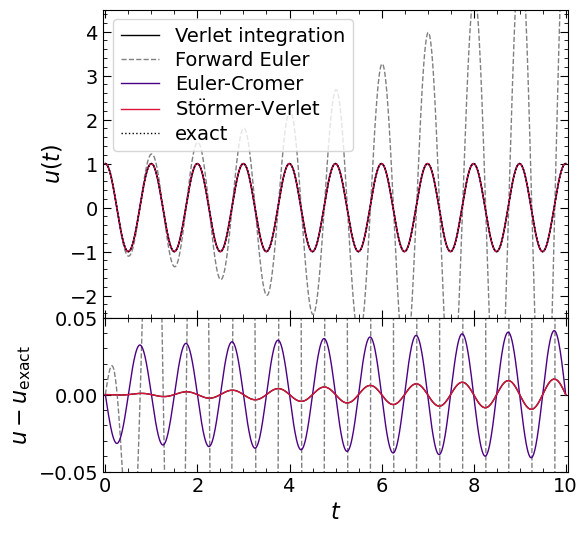

In [7]:
T_start = 0.0*T
T_end = T

plt.figure(figsize=(6,6))
gs = gridspec.GridSpec(2,1,height_ratios=[2,1],hspace=0)

ax = []
for i in range(2):
    ax_this = plt.subplot(gs[i])
    ax_this.set_xlim(T_start-0.05,T_end+0.05)
    ax_this.minorticks_on()
    ax.append(ax_this)

ax[0].set_ylim(-2.5,4.5)
ax[0].set_ylabel('$u(t)$')
ax[0].set_xticklabels('')

ax[1].set_ylim(-0.05,0.05)
ax[1].set_ylabel('$u - u_{{\\rm exact}}$')
ax[1].set_xlabel('$t$')

for scheme in soln.keys():
    u,t = soln[scheme]['u'],soln[scheme]['t']
    ls,lw,col,lab = pltdict[scheme]['ls'],pltdict[scheme]['lw'],pltdict[scheme]['col'],pltdict[scheme]['lab']
    ax[0].plot(t,u,ls=ls,lw=lw,c=col,label=lab)
    ax[1].plot(t,u-u_exact,ls=ls,lw=lw,c=col,label=lab)
ls,lw,col,lab = pltdict['exact']['ls'],pltdict['exact']['lw'],pltdict['exact']['col'],pltdict['exact']['lab']
ax[0].plot(soln['verlet']['t'],u_exact,ls=ls,lw=lw,c=col,label=lab)
ax[0].legend(loc='upper left')

plt.show()

### Convergence of solution / velocity / energy error

In [8]:
tdict_sho = {}
for scheme in sdict.keys():
    tdict_sho[scheme] = Test_ODEInt(sdict[scheme],ode_inst=sho)

---------------
ODE integration
---------------
... solving u''(t) = f(u,t) + g(v) with v = u'
... using scheme: verlet
... g_v is None
... setup complete
---------------
---------------
ODE integration
---------------
... solving u''(t) = f(u,t) + g(v) with v = u'
... using scheme: f_euler
... g_v is None
... setup complete
---------------
---------------
ODE integration
---------------
... solving u''(t) = f(u,t) + g(v) with v = u'
... using scheme: euler_cromer
... g_v is None
... setup complete
---------------
---------------
ODE integration
---------------
... solving u''(t) = f(u,t) + g(v) with v = u'
... using scheme: stoermer_verlet
... g_v is None
... setup complete
---------------


In [9]:
start_time = time()
dt_max_sho = 0.999*2/omega
dt_min_sho = 1e-5
rdict_sho = {}
print('Convergence tests:')
for scheme in sdict.keys():
    print('... '+scheme)
    rdict_sho[scheme] = {key:None for key in tdict_sho[scheme].etype_dict.keys()}
    for key in rdict_sho[scheme].keys():
        error,rate,dts = tdict_sho[scheme].convergence(T,u0,v0,theta_f=[omega],error_type=key,
                                                       dt_max=dt_max_sho,dt_min=dt_min_sho,n_evals=15)
        rdict_sho[scheme][key] = {'dts':dts,'rate':rate,'error':error}
ut.time_this(start_time)

Convergence tests:
... verlet
... f_euler
... euler_cromer
... stoermer_verlet
0 min 11.94 seconds



#### Plot

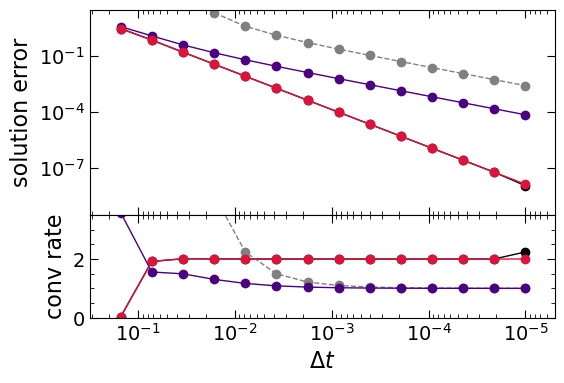

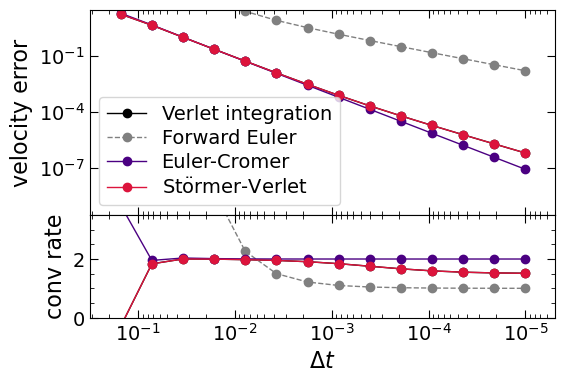

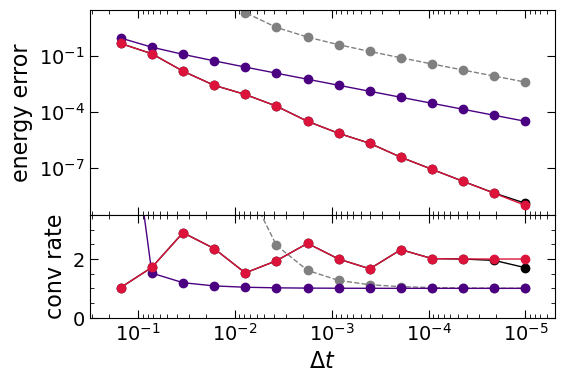

In [10]:
for error_type in rdict_sho['verlet'].keys():
    plt.figure(figsize=(6,4))
    gs = gridspec.GridSpec(2,1,height_ratios=[2,1],hspace=0)
    
    ax = []
    for i in range(2):
        ax_this = plt.subplot(gs[i])
        ax_this.set_xlim(dt_max_sho,0.5*dt_min_sho)
        ax_this.set_xscale('log')
        ax_this.minorticks_on()
        ax.append(ax_this)
    
    ax[0].set_ylim(3e-10,3e1)
    ax[0].set_yscale('log')
    ax[0].set_ylabel(error_type+' error')
    ax[0].set_xticklabels('')
    
    ax[1].set_ylim(0,3.5)
    ax[1].set_ylabel('conv rate')
    ax[1].set_xlabel('$\\Delta t$')
    
    for scheme in rdict_sho.keys():
        ls,lw,col,lab = pltdict[scheme]['ls'],pltdict[scheme]['lw'],pltdict[scheme]['col'],pltdict[scheme]['lab']
        error = rdict_sho[scheme][error_type]['error']
        rate = rdict_sho[scheme][error_type]['rate']
        dts = rdict_sho[scheme][error_type]['dts']
        ax[0].plot(dts,error,'o',ls=ls,lw=lw,c=col,label=lab)
        ax[1].plot(dts,rate,'o',ls=ls,lw=lw,c=col,label=lab)
    if error_type == 'velocity':
        ax[0].legend(loc='lower left')
    plt.show()

### Phase diagram

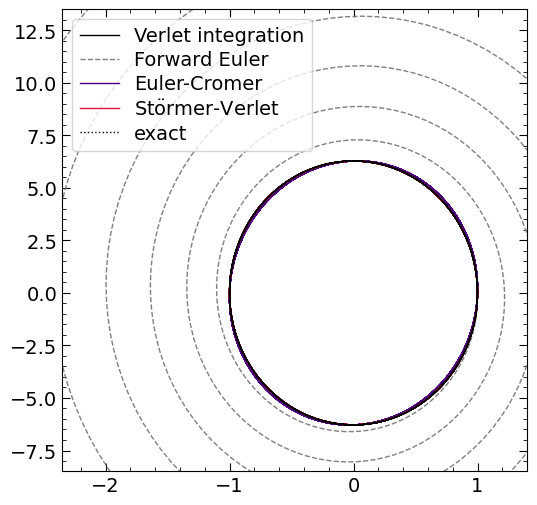

In [11]:
plt.figure(figsize=(6,6))
plt.xlim(-2.35*u0,1.4*u0)
plt.ylim(-1.35*omega*u0,2.15*omega*u0)
for scheme in soln.keys():
    ls,lw,col,lab = pltdict[scheme]['ls'],pltdict[scheme]['lw'],pltdict[scheme]['col'],pltdict[scheme]['lab']
    plt.plot(soln[scheme]['u'],soln[scheme]['v'],ls=ls,lw=lw,c=col,label=lab)
ls,lw,col,lab = pltdict['exact']['ls'],pltdict['exact']['lw'],pltdict['exact']['col'],pltdict['exact']['lab']
plt.plot(u_exact,v_exact,ls=ls,lw=lw,c=col,label=lab)
plt.legend(loc='upper left')
plt.minorticks_on()
plt.show()